## OTA: Differentiable Optimal Transport for Feature Alignment


A central challenge in unsupervised domain adaptation is minimizing the discrepancy between the source ($p_s$) and target ($p_t$) feature distributions. While classic Optimal Transport (OT), or the Earth-Mover's Distance (EMD), provides a principled metric for comparing probability distributions, its standard formulation involves solving a linear program. This is computationally expensive (super-cubic in practice) and, critically, non-differentiable, making it unsuitable for end-to-end training of deep neural networks.

To address this, we adopt the strategy proposed by [Cuturi (2013)](https://proceedings.neurips.cc/paper_files/paper/2013/file/af21d0c97db2e27e13572cbf59eb343d-Paper.pdf), which introduces an entropic regularization term to the OT problem. This regularized objective, shown in Equation (1), is defined as:

$$
d_{\lambda}(p_s, p_t) := \min_{P \in U(r,c)} \langle P, C \rangle - \frac{1}{\lambda} h(P)
\tag{1}
$$

where $C$ is the pairwise cost matrix between feature embeddings, $P$ is the transport plan, $h(P)$ is the entropy of $P$, and $\lambda$ is a regularization coefficient. In our implementation, we use $\epsilon = 1/\lambda$ directly for numerical stability. As $\lambda \to \infty$ (equivalently, $\epsilon \to 0$), the solution $P$ converges to the classic EMD solution. For $\lambda > 0$ ($\epsilon > 0$), the objective becomes strictly convex in $P$, guaranteeing a unique optimal transport plan that can be solved using the highly-efficient and numerically-stable Sinkhorn-Knopp algorithm.

Our SinkhornOTLoss module implements the entropically regularized OT solver using the Sinkhorn matrix-scaling updates described after Lemma 2 in Cuturi (2013). We use numerically stabilized updates in the linear domain: $u \leftarrow \mu / (K v + \delta)$ and $v \leftarrow \nu / (K^T u + \delta)$,
where $\delta = 10^{-8}$ prevents division by zero. The resulting transport plan is $P = \mathrm{diag}(u) K \, \mathrm{diag}(v)$, where $K = \exp(-C/\epsilon)$ is the Gibbs kernel. The final loss is the total transport cost $\langle P, C \rangle$, which provides a global measure of discrepancy between the two feature batches.

#### Proposed Composite Alignment Loss

While the entropic Sinkhorn distance $d_{\lambda}(p_s,p_t)$ provides a principled global alignment loss, it can be insensitive to local structure and outliers if used in isolation. We therefore adopt a composite alignment loss that blends the global OT cost with two complementary instance-level objectives. This multi-term loss is implemented in our `OTAlignmentLoss` module.

Our full loss, defined in Equation (2), combines three terms:

$$
\mathcal{L}_{\text{align}} =
\lambda_{ot}\, d_{\lambda}(p_s, p_t)
+ \lambda_{\text{match}}\, \mathcal{L}_{\text{match}}
+ \lambda_{\text{topk}}\, \mathcal{L}_{\text{topk}}
\tag{2}
$$

The first component, $d_{\lambda}(p_s,p_t)$, provides global distribution-level alignment.

The second component, $\mathcal{L}_{\text{match}}$, reuses the computed Sinkhorn plan $P^\lambda$ to construct a barycentric projection of target features onto the source domain. As implemented in our `matched_pair_losses` function, it is defined as
$\mathcal{L}_{\text{match}} = \mathrm{MSE}(\mathbf{X}, P^\lambda \mathbf{Y})$.
This provides a strong instance-level signal, encouraging each source feature to align with a weighted average of its corresponding target features.

The third component, $\mathcal{L}_{\text{topk}}$, penalizes the $k$ worst-aligned source features. For each source feature $x_i$, we compute the closest target $y_j$ via $\min_j C_{ij}$, and then average the $k$ largest of these minima. This highlights poorly aligned samples without being dominated by all entries of $C$.

By combining a global distribution-matching loss with a soft instance-level alignment term and a focused outlier penalty, the composite loss $\mathcal{L}_{\text{align}}$ provides a balanced and robust measure of feature alignment. In practice, we optimize the total loss rather than any single component, as the combination provides more stability and better alignment across scales.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

plt.rcParams.update({
    "figure.dpi": 120,
    "font.size": 12,
    "axes.grid": True,
})

In [ ]:
from nebula.modeling.ota_loss import OTAlignmentLoss

# Loss modules
ce_loss_fn = nn.CrossEntropyLoss()
ot_align_loss = OTAlignmentLoss(
    lambda_ot=0.25, lambda_match=0.5, lambda_topk=0.05,
    ot_epsilon=1.0, match_epsilon=1.0
)

# Shapes
B, C, D = 32, 3, 64  # batch size, number of classes, feature dimension

# Source domain (labeled)
# Logits (for Cross-Entropy)
src_logits = torch.randn(B, C, requires_grad=True)
src_labels = torch.randint(0, C, (B,))

# Source features
X = torch.randn(B, D)

Case A: Target ``Y_close`` ~ similar to source ``X``

In [3]:
# Target features Y_close: generated by adding small Gaussian noise to X
Y_close = X + 0.1 * torch.randn(B, D)

# Losses
# L_CE
ce_close = ce_loss_fn(src_logits, src_labels)
# d_lambda(p_s, p_t)
ot_close = ot_align_loss.ot_loss(X, Y_close)
# L_match
match_close = ot_align_loss.match_loss(X, Y_close)
# L_topk
topk_close = ot_align_loss.topk_loss(X, Y_close)
# L_align = L_CE + lambda_ot*ot + lambda_match*match + lambda_topk*topk
total_close = ce_close + ot_align_loss(X, Y_close)

print("=== Case A: Close (Similar) Features ===")
print(f"Total: {total_close.item():.4f} | CE: {ce_close.item():.4f} | "
      f"Match MSE: {match_close.item():.4f} | "
      f"Top-K: {topk_close.item():.4f}")

=== Case A: Close (Similar) Features ===
Total: 1.4731 | CE: 1.2652 | Match MSE: 0.0102 | Top-K: 0.8068


Case B: Target ``Y_far`` very different from source ``X``

In [4]:
# Target features Y_far: drawn from a different distribution (far from X)
Y_far = torch.randn(B, D) * 2

# Losses
# L_CE (same classifier outputs/labels)
ce_far = ce_loss_fn(src_logits, src_labels)
# d_lambda(p_s, p_t)
ot_far = ot_align_loss.ot_loss(X, Y_far)
# L_match
match_far = ot_align_loss.match_loss(X, Y_far)
# L_topk
topk_far = ot_align_loss.topk_loss(X, Y_far)
# L_align = L_CE + lambda_ot*ot + lambda_match*match + lambda_topk*topk
total_far = ce_far + ot_align_loss(X, Y_far)

print("\n=== Case B: Far (Dissimilar) Features ===")
print(f"Total: {total_far.item():.4f} | CE: {ce_far.item():.4f} | "
      f"Match MSE: {match_far.item():.4f} | "
      f"Top-K: {topk_far.item():.4f}")


=== Case B: Far (Dissimilar) Features ===
Total: 13.7481 | CE: 1.2652 | Match MSE: 0.9826 | Top-K: 239.8326


Case C: Target ``Y_identical`` identical to source ``X``

In [5]:
# Target features Y_identical: exact copy of X
Y_identical = X.clone()

# Losses
# L_CE (same classifier outputs/labels)
ce_identical = ce_loss_fn(src_logits, src_labels)
# d_lambda(p_s, p_t)
ot_identical = ot_align_loss.ot_loss(X, Y_identical)
# L_match
match_identical = ot_align_loss.match_loss(X, Y_identical)
# L_topk
topk_identical = ot_align_loss.topk_loss(X, Y_identical)
# L_align = L_CE + lambda_ot*ot + lambda_match*match + lambda_topk*topk
total_identical = ce_identical + ot_align_loss(X, Y_identical)

print("\n=== Case C: Identical Features ===")
print(f"Total: {total_identical.item():.4f} | CE: {ce_identical.item():.4f} | "
      f"Match MSE: {match_identical.item():.4f} | "
      f"Top-K: {topk_identical.item():.4f}")


=== Case C: Identical Features ===
Total: 1.2652 | CE: 1.2652 | Match MSE: 0.0000 | Top-K: 0.0000


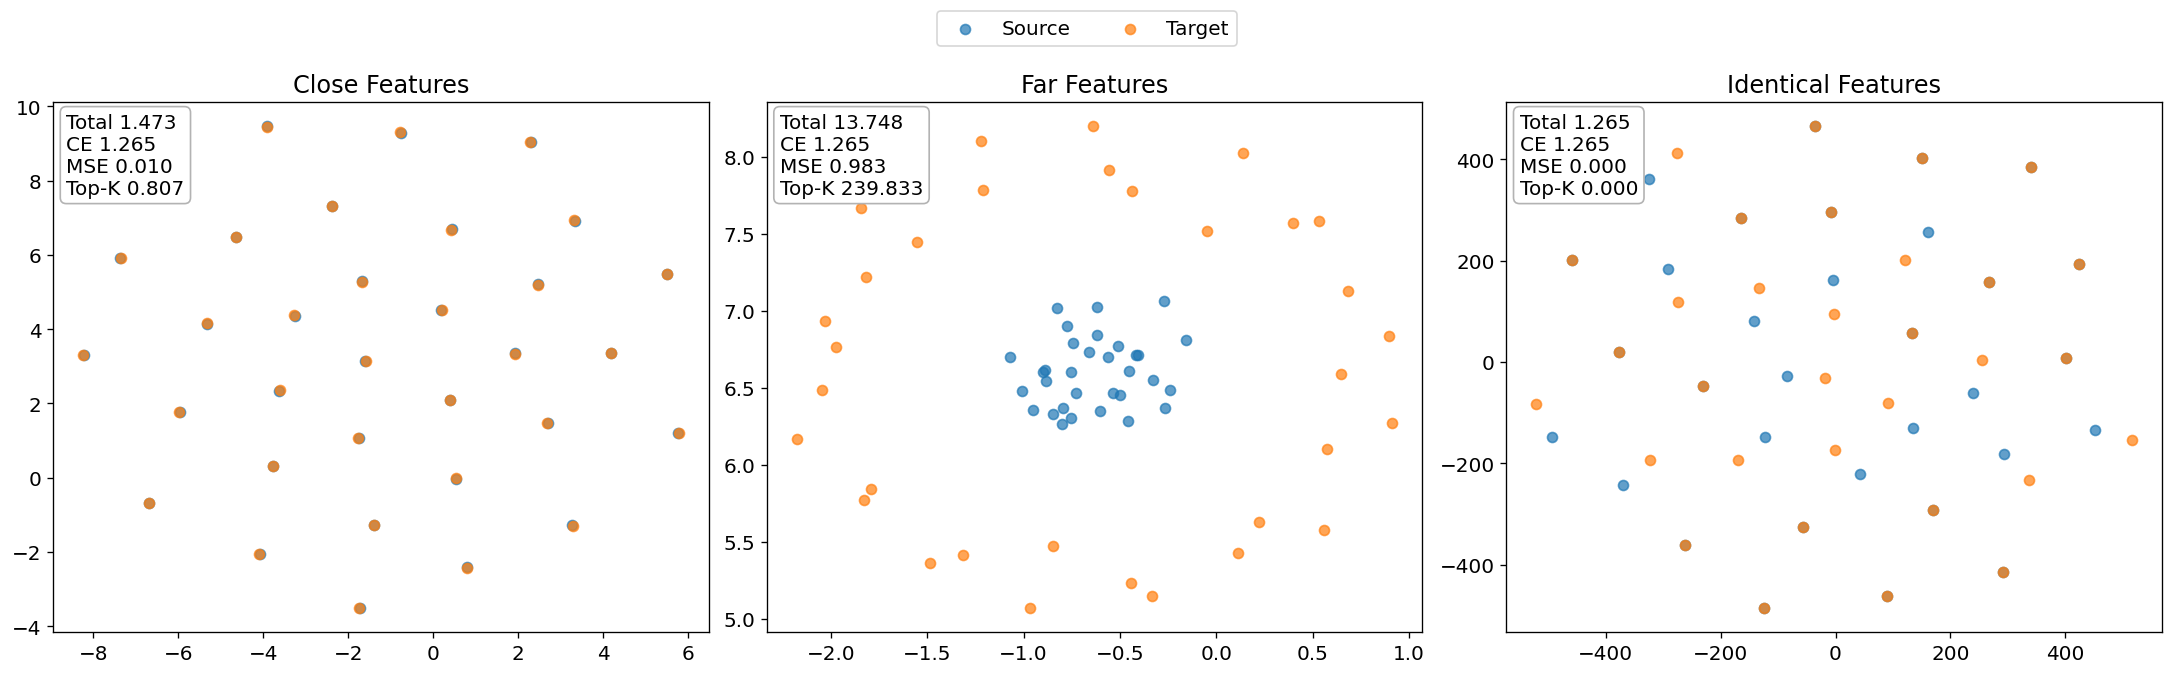

In [6]:
# X (Source), Y_close (Target Close), Y_far (Target Far), Y_identical (Target Identical)
X_np = X.detach().cpu().numpy()
Y_close_np = Y_close.detach().cpu().numpy()
Y_far_np = Y_far.detach().cpu().numpy()
Y_identical_np = Y_identical.detach().cpu().numpy()

# Fit separate t-SNEs so each panel best reflects its pairwise geometry
tsne_close = TSNE(n_components=2, random_state=SEED, perplexity=min(30, B-1), init="pca")
close_2d = tsne_close.fit_transform(np.vstack([X_np, Y_close_np]))
close_src, close_tgt = close_2d[:B], close_2d[B:]

tsne_far = TSNE(n_components=2, random_state=SEED, perplexity=min(30, B-1), init="pca")
far_2d = tsne_far.fit_transform(np.vstack([X_np, Y_far_np]))
far_src, far_tgt = far_2d[:B], far_2d[B:]

tsne_identical = TSNE(n_components=2, random_state=SEED, perplexity=min(30, B-1), init="pca")
identical_2d = tsne_identical.fit_transform(np.vstack([X_np, Y_identical_np]))
identical_src, identical_tgt = identical_2d[:B], identical_2d[B:]

# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# Panel A: Close features
ax = axes[0]
ax.scatter(close_src[:, 0], close_src[:, 1], label="Source", alpha=0.7)
ax.scatter(close_tgt[:, 0], close_tgt[:, 1], label="Target", alpha=0.7)
ax.set_title("Close Features")
ax.annotate(
    f"Total {total_close.item():.3f}\nCE {ce_close.item():.3f}\n"
    f"MSE {match_close.item():.3f}\nTop-K {topk_close.item():.3f}",
    xy=(0.02, 0.98), xycoords="axes fraction",
    va="top", ha="left", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.7")
)
ax.grid(False)

# Panel B: Far features
ax = axes[1]
ax.scatter(far_src[:, 0], far_src[:, 1], label="Source", alpha=0.7)
ax.scatter(far_tgt[:, 0], far_tgt[:, 1], label="Target", alpha=0.7)
ax.set_title("Far Features")
ax.annotate(
    f"Total {total_far.item():.3f}\nCE {ce_far.item():.3f}\n"
    f"MSE {match_far.item():.3f}\nTop-K {topk_far.item():.3f}",
    xy=(0.02, 0.98), xycoords="axes fraction",
    va="top", ha="left", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.7")
)
ax.grid(False)

# Panel C: Identical features
ax = axes[2]
ax.scatter(identical_src[:, 0], identical_src[:, 1], label="Source", alpha=0.7)
ax.scatter(identical_tgt[:, 0], identical_tgt[:, 1], label="Target", alpha=0.7)
ax.set_title("Identical Features")
ax.annotate(
    f"Total {total_identical.item():.3f}\nCE {ce_identical.item():.3f}\n"
    f"MSE {match_identical.item():.3f}\nTop-K {topk_identical.item():.3f}",
    xy=(0.02, 0.98), xycoords="axes fraction",
    va="top", ha="left", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.7")
)
ax.grid(False)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, frameon=True, bbox_to_anchor=(0.5, 1.02))

plt.show()

## Per-Class Analysis

Now let's analyze the alignment loss per class. We'll create 3 distinct classes with separate source and target features for each.


In [7]:
# Per-class setup
n_classes = 3
samples_per_class = 16  # samples per class
D = 64  # feature dimension

# Create class centers (well-separated)
class_centers = torch.tensor([
    [-2.0, 0.0] + [0.0] * (D - 2),  # Class 0
    [0.0, 2.0] + [0.0] * (D - 2),   # Class 1
    [2.0, 0.0] + [0.0] * (D - 2),   # Class 2
], dtype=torch.float32)

# Generate source features for each class
X_per_class = []
Y_per_class = []
labels_per_class = []

for c in range(n_classes):
    # Source features: samples around class center
    X_c = class_centers[c].unsqueeze(0) + 0.5 * torch.randn(samples_per_class, D)
    X_per_class.append(X_c)
    
    # Target features: different scenarios per class
    # Class 0: well-aligned (close to source)
    # Class 1: moderately misaligned
    # Class 2: poorly aligned (far from source)
    if c == 0:
        Y_c = X_c + 0.1 * torch.randn(samples_per_class, D)  # Well-aligned
    elif c == 1:
        Y_c = X_c + 0.5 * torch.randn(samples_per_class, D)  # Moderate
    else:
        Y_c = class_centers[c].unsqueeze(0) + 1.5 * torch.randn(samples_per_class, D)  # Poor alignment
    
    Y_per_class.append(Y_c)
    labels_per_class.append(torch.full((samples_per_class,), c, dtype=torch.long))

# Combine all classes
X_all = torch.cat(X_per_class, dim=0)
Y_all = torch.cat(Y_per_class, dim=0)
labels_all = torch.cat(labels_per_class, dim=0)

print(f"Total samples: {X_all.shape[0]} ({samples_per_class} per class)")
print(f"Feature dimension: {D}")
print(f"Number of classes: {n_classes}")

Total samples: 48 (16 per class)
Feature dimension: 64
Number of classes: 3


In [8]:
# Compute losses per class
class_losses = {
    'match': [],
    'topk': [],
    'total': [],
    'class_names': []
}

for c in range(n_classes):
    X_c = X_per_class[c]
    Y_c = Y_per_class[c]
    
    # Compute individual losses
    match_c = ot_align_loss.match_loss(X_c, Y_c)
    topk_c = ot_align_loss.topk_loss(X_c, Y_c)
    total_c = ot_align_loss(X_c, Y_c)
    
    class_losses['match'].append(match_c.item())
    class_losses['topk'].append(topk_c.item())
    class_losses['total'].append(total_c.item())
    class_losses['class_names'].append(f'Class {c}')

# Print results
print(f"{'Class':<10} {'Match MSE':<12} {'Top-K':<10} {'Total':<10}")
print("-" * 45)
for c in range(n_classes):
    print(f"{class_losses['class_names'][c]:<10} "
          f"{class_losses['match'][c]:<12.4f} "
          f"{class_losses['topk'][c]:<10.4f} "
          f"{class_losses['total'][c]:<10.4f}")

# Overall loss (all classes combined)
match_overall = ot_align_loss.match_loss(X_all, Y_all)
topk_overall = ot_align_loss.topk_loss(X_all, Y_all)
total_overall = ot_align_loss(X_all, Y_all)

print(f"\n{'Overall':<10} {match_overall.item():<12.4f} {topk_overall.item():<10.4f} "
      f"{total_overall.item():<10.4f}")

Class      Match MSE    Top-K      Total     
---------------------------------------------
Class 0    0.0101       0.7465     0.2044    
Class 1    0.2457       18.3649    4.9730    
Class 2    0.2950       117.3464   6.0148    

Overall    0.1836       41.7159    3.5424    


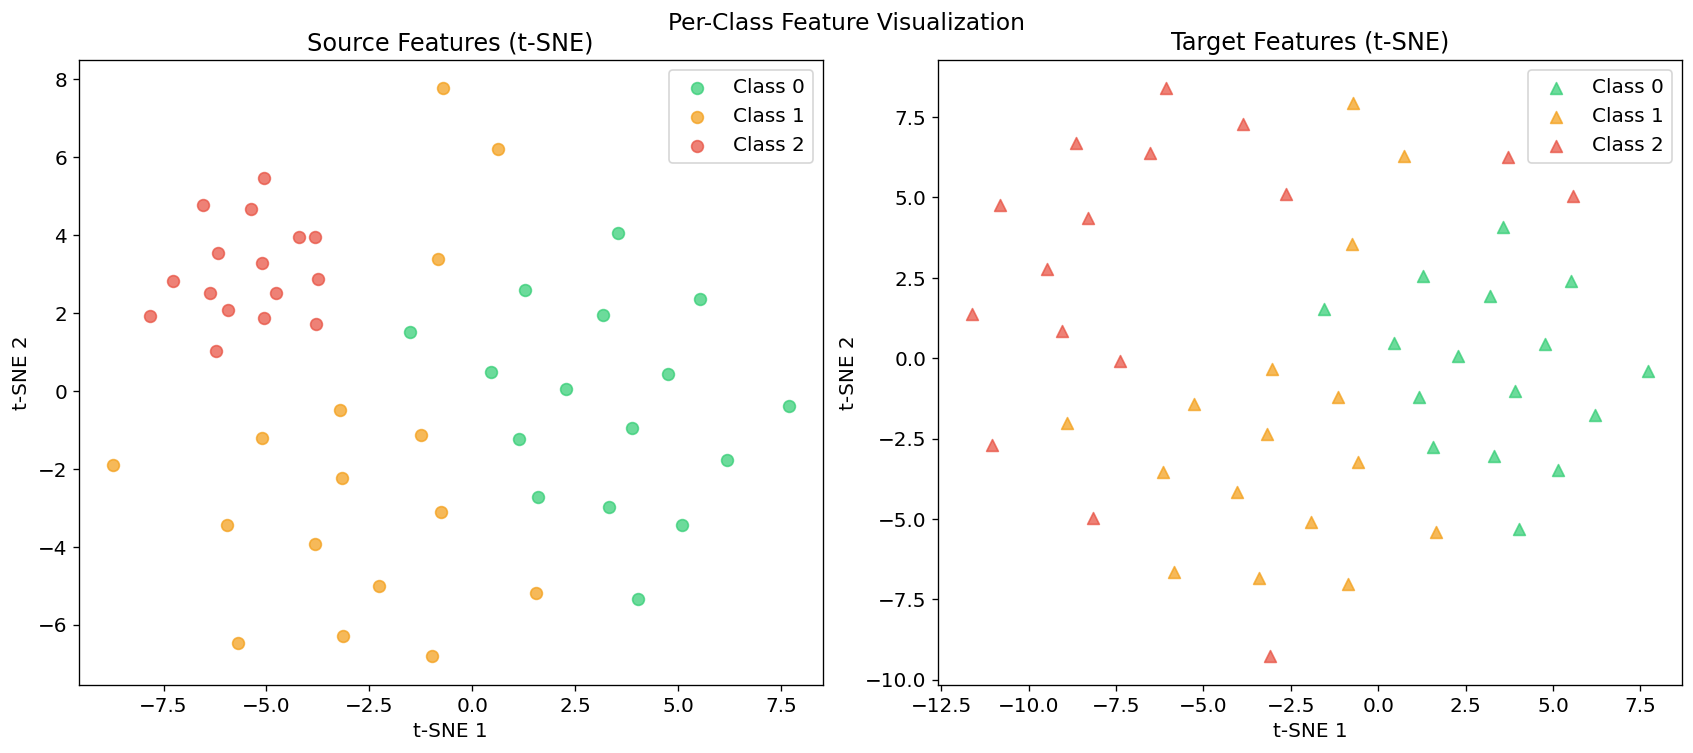

In [ ]:
# t-SNE visualization per class
X_all_np = X_all.detach().cpu().numpy()
Y_all_np = Y_all.detach().cpu().numpy()
labels_all_np = labels_all.detach().cpu().numpy()

# Fit t-SNE on combined data
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, init="pca")
all_2d = tsne.fit_transform(np.vstack([X_all_np, Y_all_np]))
X_2d = all_2d[:len(X_all_np)]
Y_2d = all_2d[len(X_all_np):]

# Plot with class colors
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

colors = ['#2ecc71', '#f39c12', '#e74c3c']  # Green, Orange, Red
class_names = ['Class 0 (Well-aligned)', 'Class 1 (Moderate)', 'Class 2 (Poor)']

# Source features
ax = axes[0]
for c in range(n_classes):
    mask = labels_all_np == c
    ax.scatter(X_2d[mask, 0], X_2d[mask, 1], 
              c=colors[c], label=f'Class {c}', alpha=0.7, s=50, marker='o')
ax.set_title('Source Features (t-SNE)')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.legend()
ax.grid(False)

# Target features
ax = axes[1]
for c in range(n_classes):
    mask = labels_all_np == c
    ax.scatter(Y_2d[mask, 0], Y_2d[mask, 1], 
              c=colors[c], label=f'Class {c}', alpha=0.7, s=50, marker='^')
ax.set_title('Target Features (t-SNE)')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.legend()
ax.grid(False)

plt.suptitle('Per-Class Feature Visualization', fontsize=14, y=1.02)
plt.show()

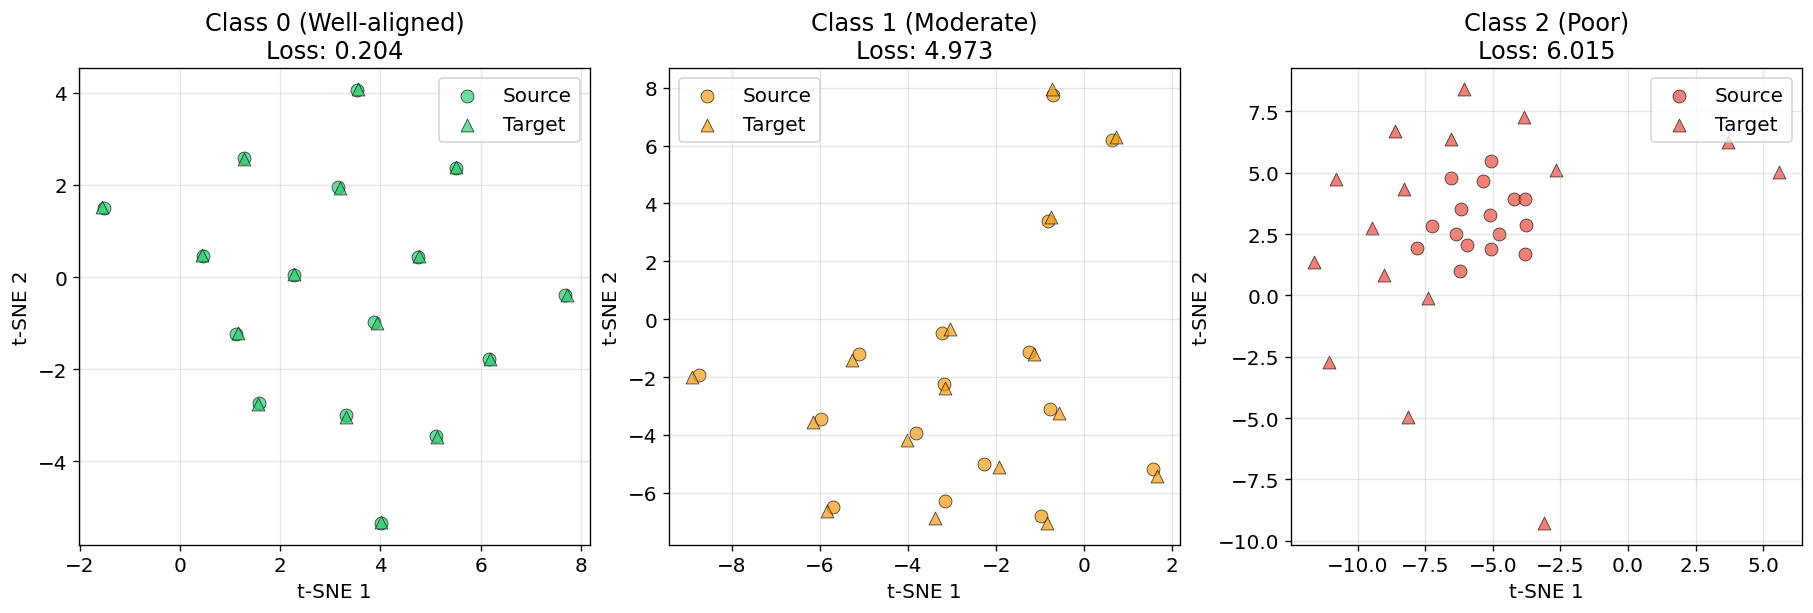

In [ ]:
# Combined visualization: source and target together per class
fig, axes = plt.subplots(1, n_classes, figsize=(15, 5), constrained_layout=True)

for c in range(n_classes):
    ax = axes[c]
    mask = labels_all_np == c
    
    # Source and target for this class
    X_c_2d = X_2d[mask]
    Y_c_2d = Y_2d[mask]
    
    ax.scatter(X_c_2d[:, 0], X_c_2d[:, 1], 
              c=colors[c], label='Source', alpha=0.7, s=60, marker='o', edgecolors='black', linewidths=0.5)
    ax.scatter(Y_c_2d[:, 0], Y_c_2d[:, 1], 
              c=colors[c], label='Target', alpha=0.7, s=60, marker='^', edgecolors='black', linewidths=0.5)
    
    ax.set_title(f'{class_names[c]}\nLoss: {class_losses["total"][c]:.3f}')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.show()